## Models
- SMOTE
- ROSE
- One-class SVM, SGD one-class SVM
- Isolation forest
- Local outlier factor
- Elliptical envelope
- Logistic?
- RF?
- XGBoost?

In [36]:
import os
from datetime import datetime
import time
import warnings
warnings.simplefilter('ignore')
import pickle
import numpy as np
from numpy.random import seed, randint
import pandas as pd
import six
import sys
sys.modules['sklearn.externals.six'] = six
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import roc_auc_score
import joblib


SMALL_FONT = {'family': 'monospace', 'size': 11}
MEDIUM_FONT = {'family': 'monospace', 'size': 14}
LARGE_FONT = {'family': 'monospace', 'weight': 'bold', 'size': 20 }

RANDOM_SEED = 42

class Models:

    X_train: pd.DataFrame
    y_train: pd.Series
    X_train_resampled: pd.DataFrame
    y_train_resampled: pd.Series

    X_train_overfit: pd.DataFrame
    y_train_overfit: pd.Series

    X_test: pd.DataFrame
    y_test: pd.Series

    training_results_df: pd.DataFrame

    current_datetime = datetime.now().strftime('%m%d%Y_%H%M%S')

    clfs= {'random_forest': RandomForestClassifier(n_jobs=-1),
           'svm_clf': SVC(max_iter=3000),
           'xgboost': XGBClassifier(n_jobs=-1, use_label_encoder=False),
           'logistic': LogisticRegression(n_jobs=-1),
           'knn': KNeighborsClassifier(n_jobs=-1)}
    n_clfs: int = len(clfs)
    clf_list = list(clfs.keys())

    search_space = {'random_forest': {'n_estimators': [10, 100, 500], 'max_features': [2, 4, 6]},
                    'svm_clf': {'C': [.01, .1, 1, 10], 'kernel': ['rbf', 'linear', 'poly']},
                    'xgboost': {'n_estimators': [100, 500, 1000], 'max_depth': [2, 4, 6, 8, 10]},
                    'logistic': {'penalty': ['l1', 'l2', 'elasticnet'], 'C': [0.1, 0.5, 0.8], 'warm_start': [True, False]},
                    'knn': {'n_neighbors': [3, 5, 10], 'weights': ['uniform', 'distance']}}

    def __init__(self):
        for df in ['X_train', 'y_train', 'X_test', 'y_test']:
            with open(f'./pickles/{df}.obj', 'rb') as f:
                setattr(self, f'{df}', pickle.load(f))

    def perform_resampling(self, downsampling: bool = False, down_ratio: float = 1.0, up_ratio: float = 0.5):
        X_cols = self.X_train.columns
        if downsampling:
            smote = SMOTE(sampling_strategy=up_ratio)
            undersampler = RandomUnderSampler(sampling_strategy=down_ratio)
            pipeline = Pipeline(steps=[('smote', smote), ('undersampler', undersampler)])
            # X, y = smote.fit_resample(self.X_train, self.y_train)
            # X, y = undersampler.fit_resample(self.X_train, self.y_train)
        else:
            smote = SMOTE()
            # X, y = smote.fit_resample(self.X_train, self.y_train)
            pipeline = Pipeline(steps=[('smote', smote)])

        X, y = pipeline.fit_resample(self.X_train, self.y_train)
        self.X_train_resampled, self.y_train_resampled = pd.DataFrame(X, columns=X_cols), pd.Series(y, name='target')
        print('Resampling completed.')

        val_counts_before = self.y_train.value_counts()
        val_counts_after = self.y_train_resampled.value_counts()

        mpl.rc('font', **LARGE_FONT)
        fig, ax = plt.subplots(1, 2, figsize=(30,10), sharey=True)
        fig.suptitle('Resampled class distribution')
        ax_titles = ['Before resampling', 'After resampling']

        for i, vals in enumerate([val_counts_before, val_counts_after]):
            sns.barplot(x=['<50k', '>=50k'], y=vals.values, ax=ax[i])
            ax[i].set_title(ax_titles[i])

        def show_values_on_bars(axs):
            def _show_on_single_plot(ax):
                for p in ax.patches:
                    _x = p.get_x() + p.get_width() / 2
                    _y = p.get_y() + p.get_height()
                    value = '{:.0f}'.format(p.get_height())
                    ax.text(_x, _y*1.01, value, ha="center")

            if isinstance(axs, np.ndarray):
                for idx, ax in np.ndenumerate(axs):
                    _show_on_single_plot(ax)
            else:
                _show_on_single_plot(axs)

        show_values_on_bars(ax)
        plt.tight_layout()
        plt.show()

    def train_model(self, overfit_test: bool = False, random_seed: int = RANDOM_SEED):
        if overfit_test:
            seed(random_seed)
            random_values = randint(0, len(self.y_train_resampled), 50)
            self.X_train_resampled, self.y_train_resampled = self.X_train_resampled.iloc[random_values], self.y_train_resampled.iloc[random_values]

        if not os.path.isdir(f'./trained_models/{self.current_datetime}'): os.mkdir(f'./trained_models/{self.current_datetime}')

        cv_outer = KFold(n_splits=self.n_clfs, shuffle=True)
        cv_inner = KFold(n_splits=3, shuffle=True)
        results = {}

        i = 0
        for train_ix, test_ix in cv_outer.split(self.X_train_resampled):

            X_train, X_test = self.X_train_resampled.iloc[train_ix], self.X_train_resampled.iloc[test_ix]
            y_train, y_test = self.y_train_resampled.iloc[train_ix], self.y_train_resampled.iloc[test_ix]

            model_training_start = time.time()
            model = self.clfs[self.clf_list[i]]

            search_space = self.search_space[self.clf_list[i]]
            search = GridSearchCV(model, search_space, scoring='roc_auc', cv=cv_inner, refit=True, n_jobs=-1)

            result = search.fit(X_train, y_train, eval_metric='logloss') if self.clf_list[i] in ['xgboost'] else search.fit(X_train, y_train)
            best_model = result.best_estimator_
            if not overfit_test: joblib.dump(best_model, f'./trained_models/{self.current_datetime}/{self.clf_list[i]}.pkl')

            y_hat = best_model.predict(X_test)
            roc_auc_test = roc_auc_score(y_test, y_hat)
            model_training_time = time.time() - model_training_start
            results[f'{self.clf_list[i]}'] = [roc_auc_test, result.best_score_, result.best_params_, model_training_time]
            print(f'>{self.clf_list[i]} training complete, time elapsed={model_training_time}')

            i+=1

        self.training_results_df = pd.DataFrame.from_dict(results, orient='index', columns=['k-fold test roc auc', 'k-fold validation roc_auc', 'hyperparams', 'training time'])
        display(self.training_results_df.sort_values('k-fold test roc auc', ascending=False))

    def test_set_eval(self):
        model_list = [f'./trained_models/{self.current_datetime}/{self.clf_list[i]}' for i in range(self.n_clfs)]
        results = []

        for i, models in enumerate(model_list):
            with open(models, 'rb') as f:
                model = pickle.load(f)

            y_hat = model.predict(self.X_test)
            roc_auc = roc_auc_score(self.y_test, y_hat)
            results.append(roc_auc)

        self.training_results_df['test set roc_auc'] = results
        display(self.training_results_df.sort_values(['test set roc_auc', 'k-fold test roc auc'], ascending=False))



Resampling completed.


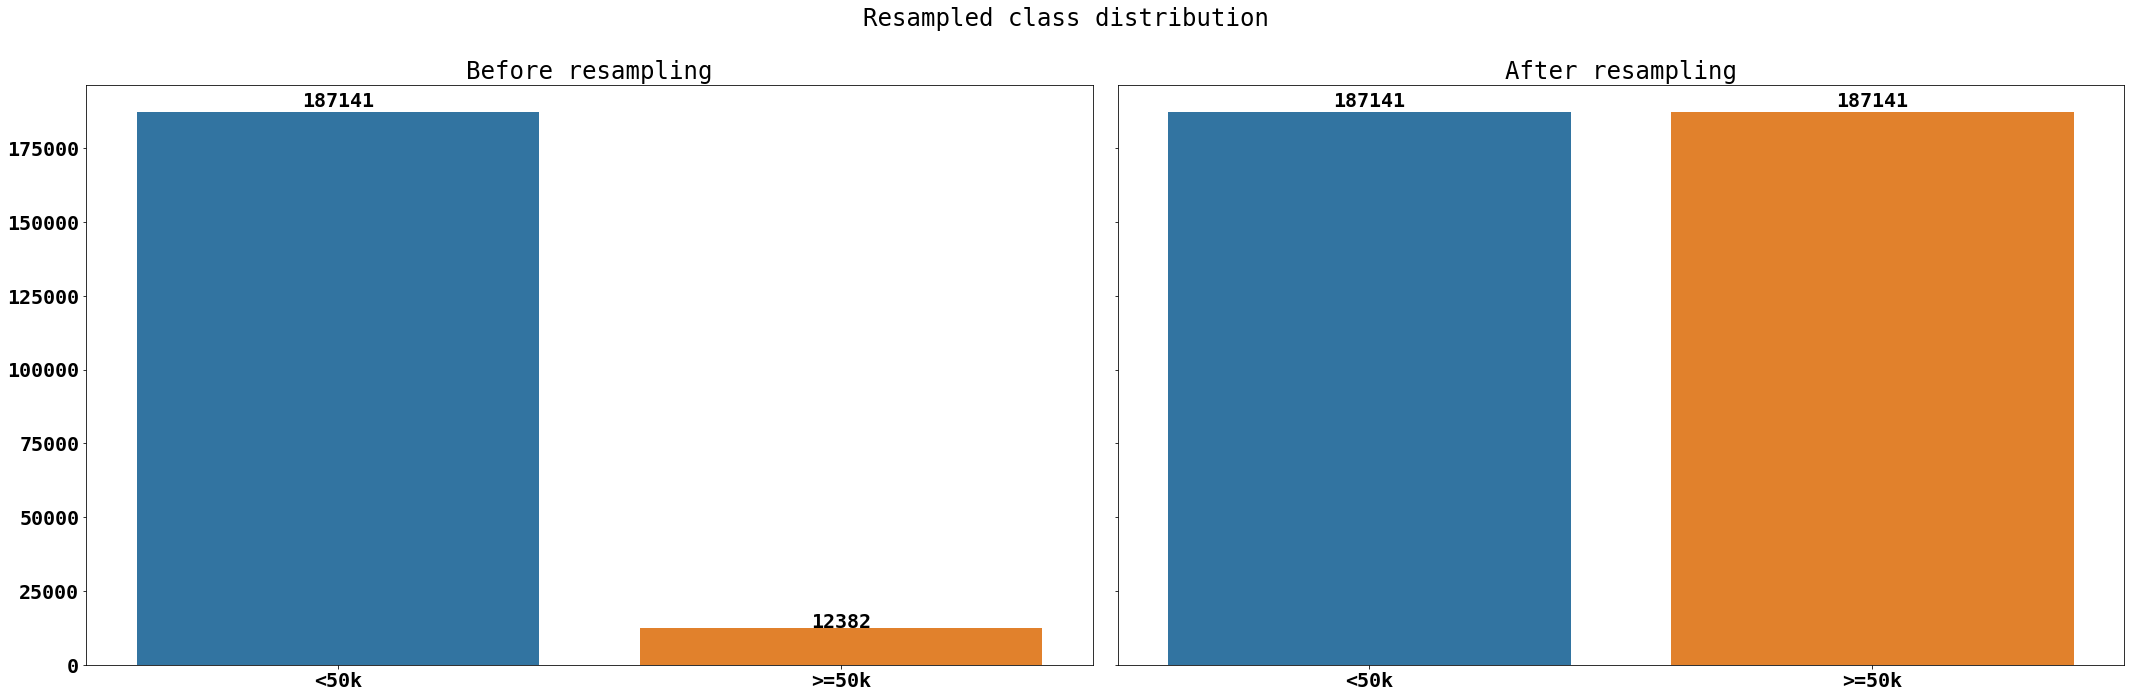

In [24]:
resampling_methods1 = Models()
resampling_methods1.perform_resampling()

Resampling completed.


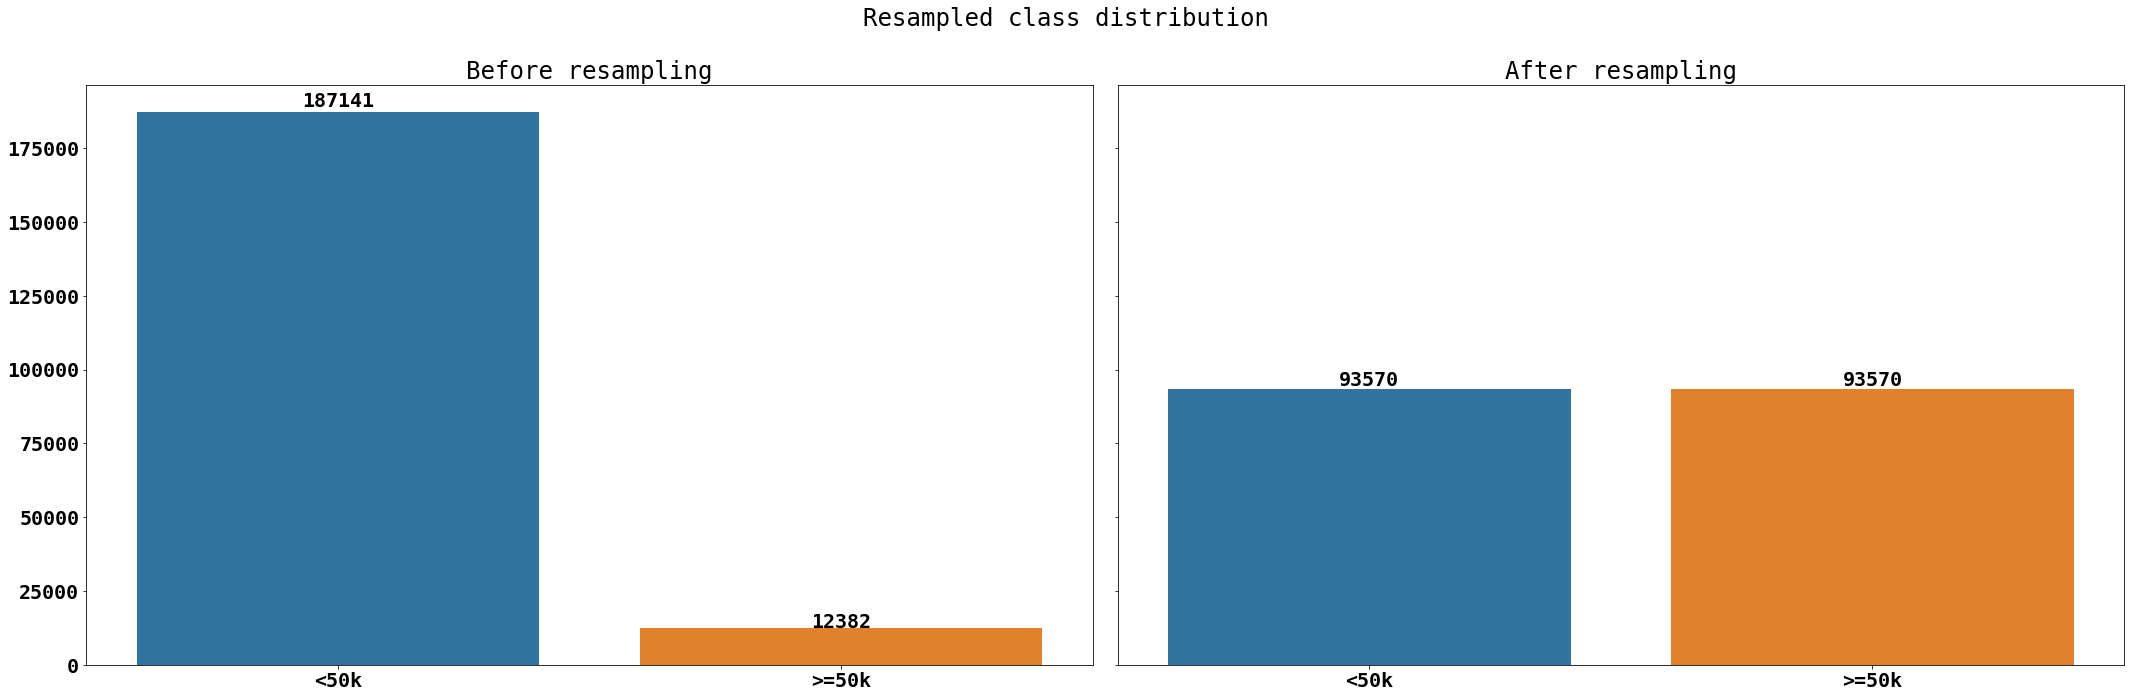

In [25]:
resampling_methods2 = Models()
resampling_methods2.perform_resampling(downsampling=True, down_ratio=1.0, up_ratio=0.5)

Resampling completed.


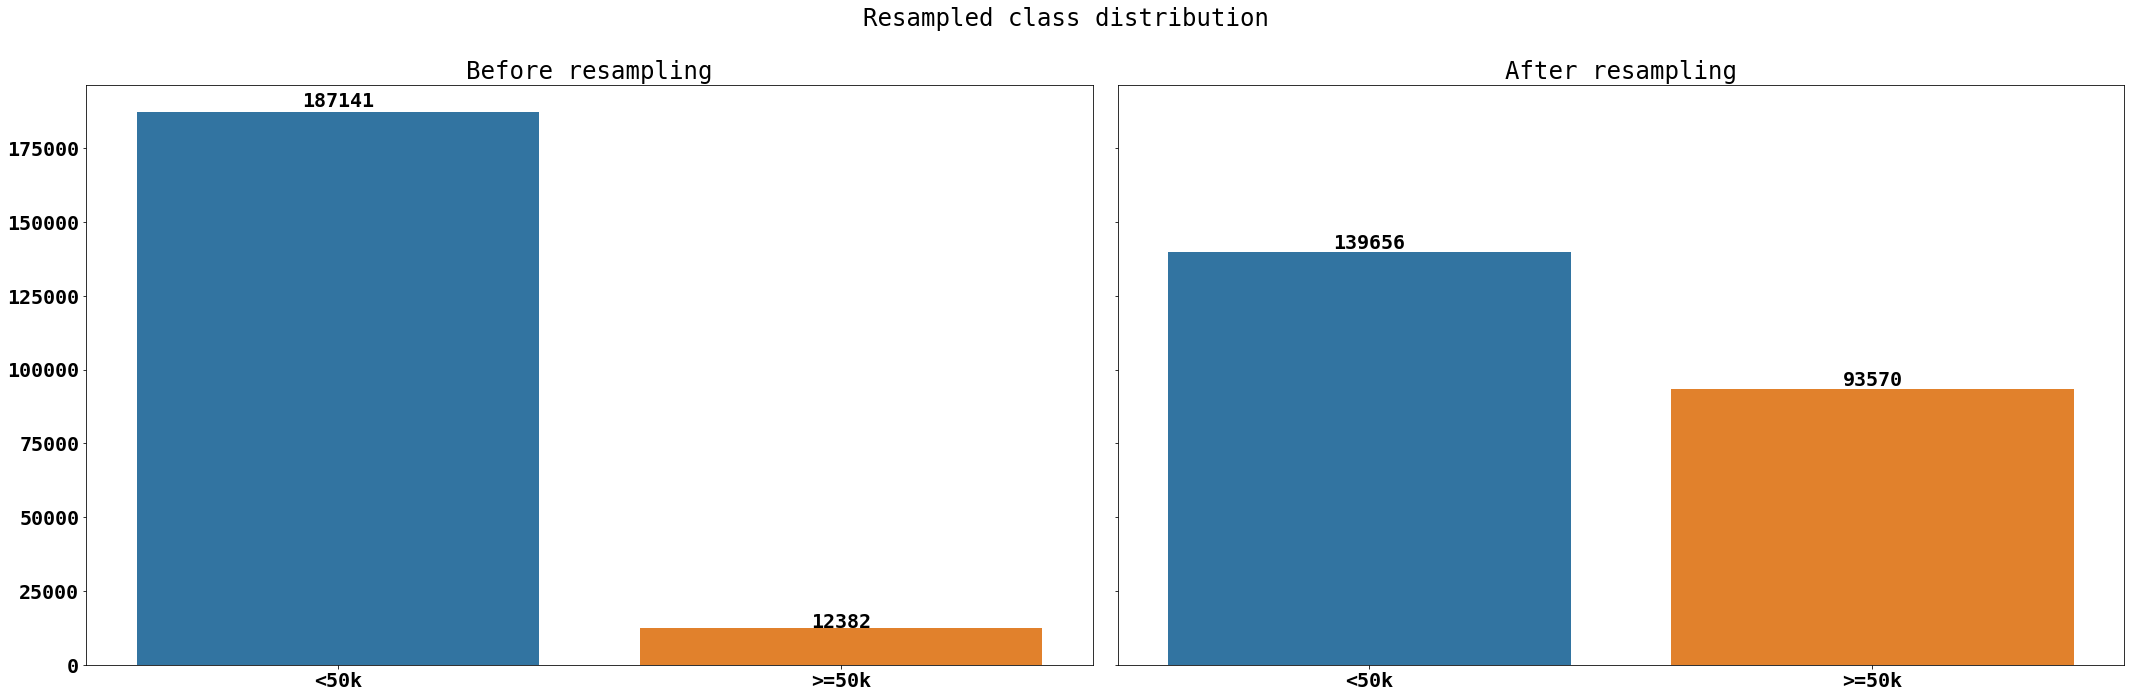

In [26]:
resampling_methods3 = Models()
resampling_methods3.perform_resampling(downsampling=True, down_ratio=0.67, up_ratio=0.5)

Resampling completed.


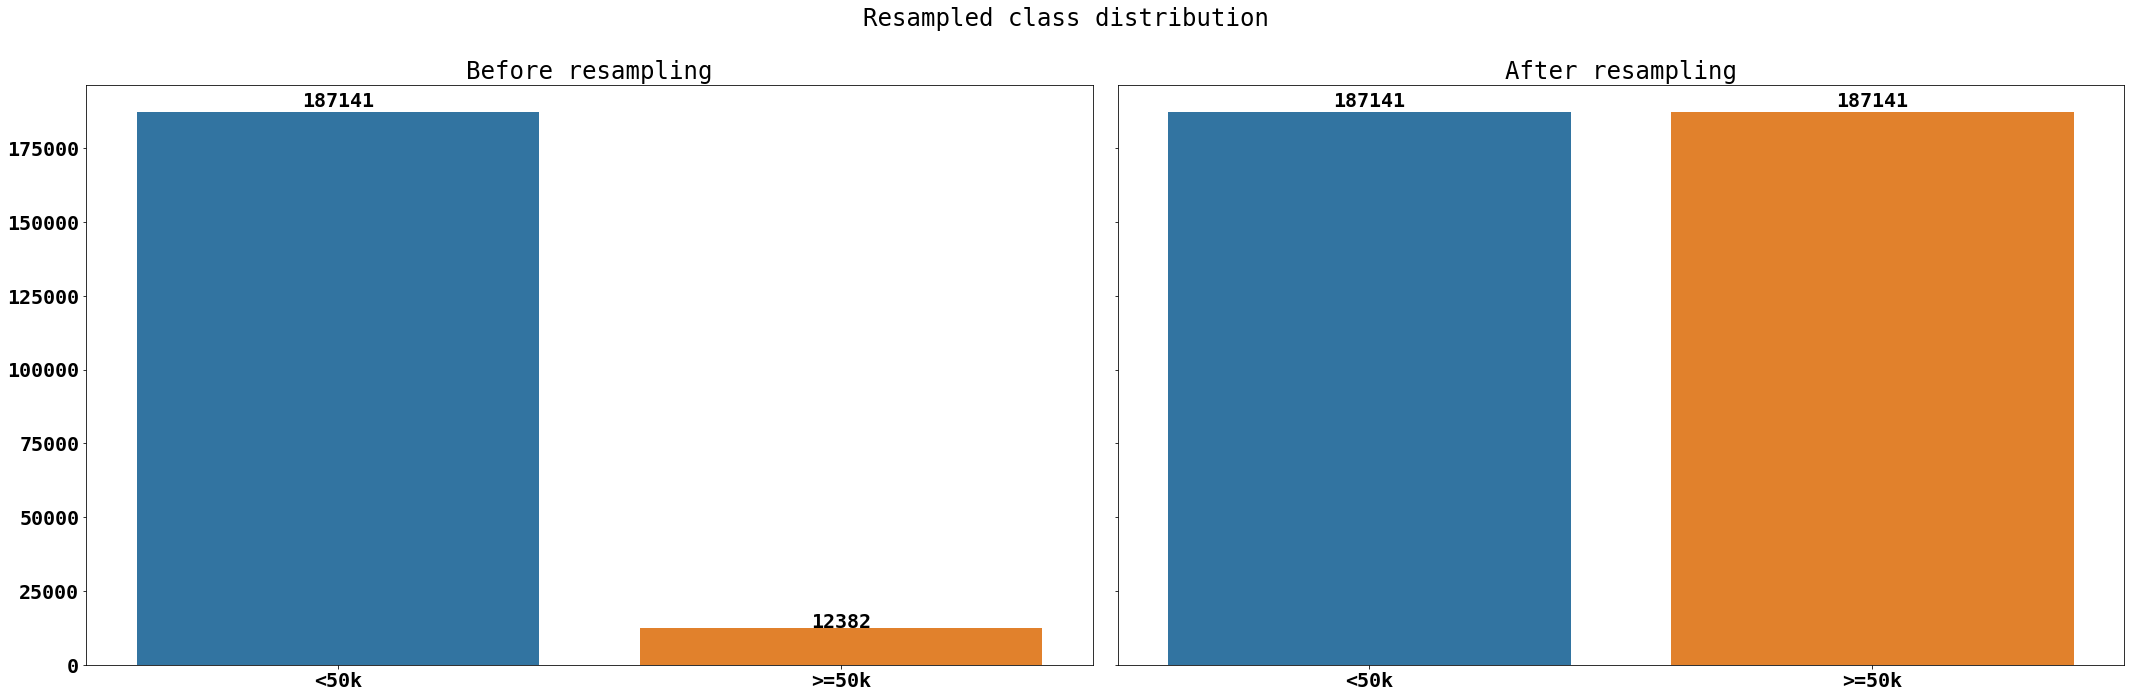

In [34]:
overfit_test = Models()
overfit_test.perform_resampling()

In [35]:
overfit_test.train_model(overfit_test=True)

>logistic training complete, time elapsed=1635106324.5921023
>logistic training complete, time elapsed=1635106325.7011008


,test set roc auc,best validation set roc_auc,hyperparams,training time
logistic,0.84375,0.911111,"{'C': 0.5, 'penalty': 'l2', 'warm_start': True}",0.85531


In [37]:
model_train = Models()

Resampling completed.


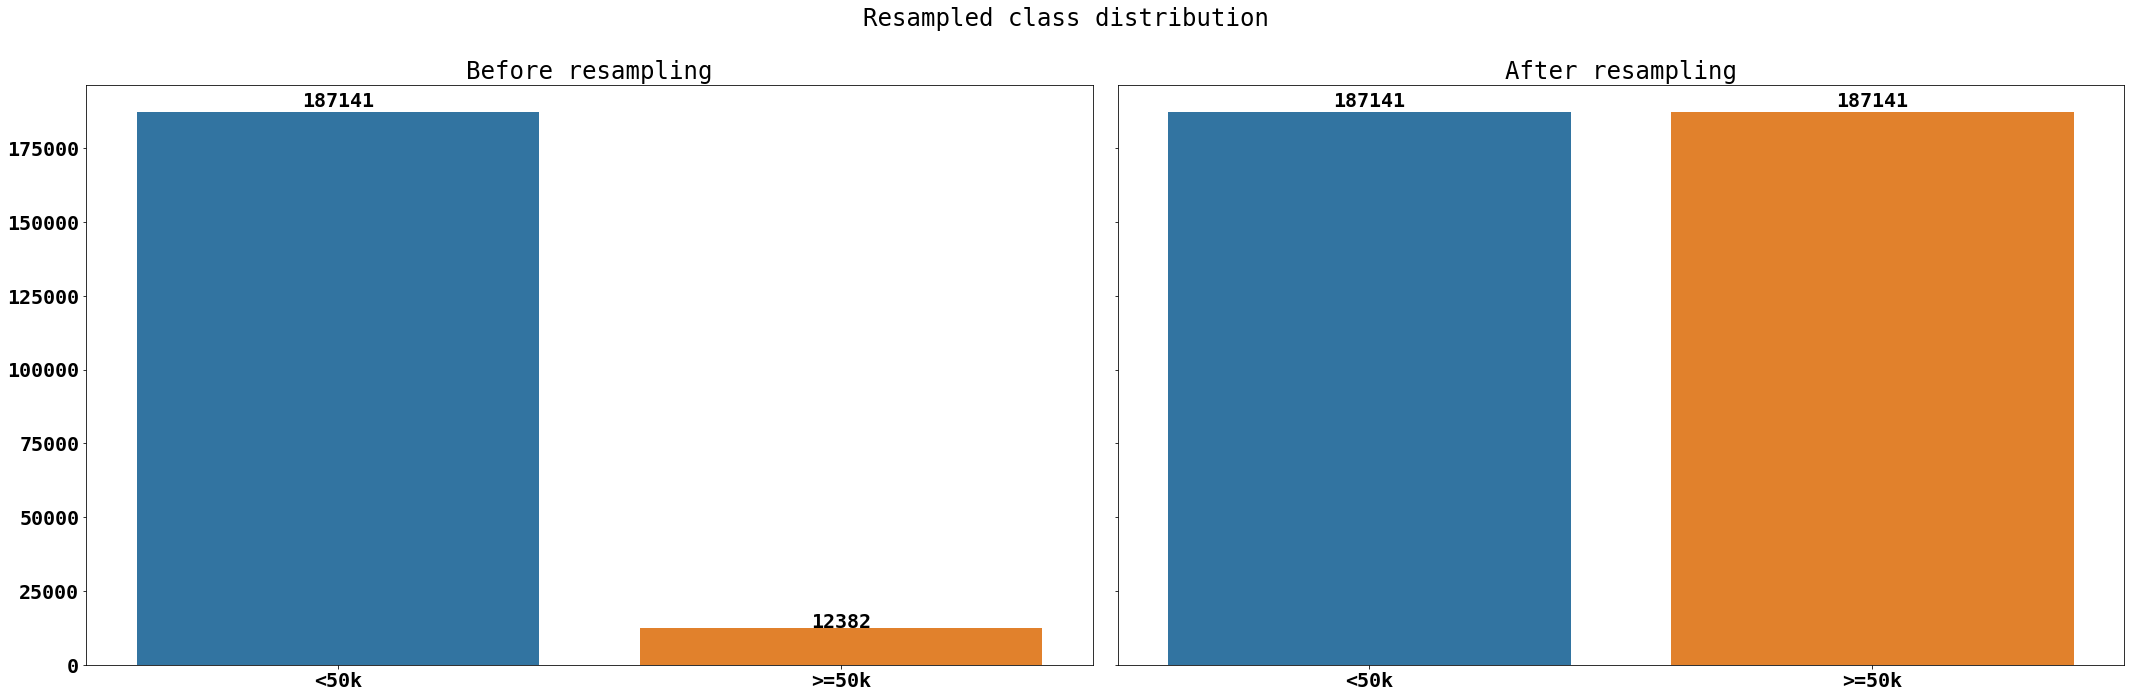

>logistic training complete, time elapsed=30.54808521270752
>logistic training complete, time elapsed=31.22161626815796


,test set roc auc,best validation set roc_auc,hyperparams,training time
logistic,0.869654,0.941514,"{'C': 0.8, 'penalty': 'l2', 'warm_start': True}",31.221616


In [38]:
model_train.perform_resampling()
model_train.train_model()